In [175]:
import io, os, re, logging, datetime, sys
import requests, tqdm, tarfile, itertools, html, time
import numpy as np
import pandas as pd
import dask.dataframe as dd

import plotly.express as px
from dateparser import parse
from fuzzywuzzy import process, fuzz

sys.path.append("../")

from src.visualization.visualize import visualize_shot
from src.features.categorical import *
from src.transformations import *
from src.transformations.arrays import numpy_fill
pd.set_option('display.max_rows', 20)

# Load all public shot IDs by iterating through pages from database

In [2]:
# Load list of shots
pages_df = pd.read_csv("../data/raw/visualizercoffee_shot_ids_2021-12-18.csv")

pages_df

,clock,id
0,1636526780,14899484-a5f8-4ccc-b372-79700c8150ae
1,1636526752,76f936ee-5147-40ac-986e-f0f1be5ac97e
2,1636526738,8853ae7c-5bf8-4194-93dd-462de63f1471
3,1636526681,a4d7a358-fc3f-451c-92f5-756adaa4a7dd
4,1636526665,3ebcfff9-fb6f-47f6-a3df-affe01d55150
...,...,...
73213,1274388447,a68afc41-645d-46c6-bfce-3dc9bf95ed0b
73214,1274388290,a37b6160-3e6a-4860-97cc-6b75a035c0da
73215,1274387176,3849dd2f-1678-488b-8f76-b166f53fe7ed
73216,1274386903,5a5d218e-7d84-4a8c-9621-f3067b0b8fb5


In [5]:
# n_pages = 7321
data_pages = []

def get_page_json(page_num):
    response = requests.get(f'https://visualizer.coffee/api/shots?page={page_num}',)
    obj = response.json()
    return obj["data"]

for page_num in tqdm.tqdm(range(7321, 8631+1)):
    data = get_page_json(page_num)
    data_pages.extend(data)

new_pages_df = pd.DataFrame.from_dict(data_pages).drop_duplicates()

# Multi-worker 
# npartitions = 24
# pages = pd.Series(range(1589, n_pages+1))

# rest_df = dd.from_pandas(pages, npartitions=npartitions).apply(lambda pages: get_page_json(page), meta=list).compute()
pages_df = pd.concat([pages_df, new_pages_df], axis=0).drop_duplicates()
pages_df.to_csv("../data/raw/visualizercoffee_shot_ids_2021-12-18.csv", index=False)

In [7]:
def get_shot_json(shot_id):
    response = requests.get(f'https://visualizer.coffee/api/shots/{shot_id}/download',)
    obj = response.json()
    return obj

In [8]:
def json_to_series(data):
    if "error" in data: return False
    
    shot_df = pd.DataFrame({k:v for k,v in data.items() if k not in ["data", "timeframe"]}, 
                           index=pd.Index([data["id"]], name="id"))
    
    shot_df = pd.DataFrame.from_dict({k:v for k,v in data.items() if k not in ["data", "timeframe"]}, orient="index")[0]

    timeframe = pd.Index(data["timeframe"]+[data["timeframe"][-1]], name="timeframe").astype(float)
    shot_df["timeframe"] = timeframe.tolist()

    series_df = pd.DataFrame(data["data"]).astype(float)
    
    for key, values in series_df.to_dict(orient='list').items():
        shot_df[key] = np.array(values)

    return shot_df

In [12]:
shot_series = []

for shot_id in tqdm.tqdm(new_pages_df["id"]):
    data = get_shot_json(shot_id)
    
    try:
        shot_json = json_to_series(data)
        if not isinstance(shot_json, pd.Series): 
            continue
        shot_series.append(shot_json)
        
    except:
        logging.info(f"error for shot {shot_id}")

        
new_shots_df = pd.concat(shot_series, axis=1).T

100%|███████████████████████████████████| 13109/13109 [2:03:02<00:00,  1.78it/s]


In [22]:
new_pages_df["id"]

,clock,id
0,1618494554,65851316-b83e-4676-a072-c34b6b572a0b
1,1618494483,2c2bad25-d6f6-4058-a571-1c5ae925ebe9
2,1618494266,16d5f8e1-a087-45b8-a623-bdec4445e9a8
3,1618493724,3ddb33ba-1754-4bd2-b1b6-e1969d5ac240
4,1618493724,fe266d43-86f4-4e0e-8cda-243ef98eb395
...,...,...
13105,1274388447,a68afc41-645d-46c6-bfce-3dc9bf95ed0b
13106,1274388290,a37b6160-3e6a-4860-97cc-6b75a035c0da
13107,1274387176,3849dd2f-1678-488b-8f76-b166f53fe7ed
13108,1274386903,5a5d218e-7d84-4a8c-9621-f3067b0b8fb5


In [21]:
combined_shots_df = pd.concat([shots_df, new_shots_df], axis=0).drop_duplicates(subset=["id"])

combined_shots_df.shape, combined_shots_df["id"].nunique()

((73202, 36), 73202)

In [19]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_shot_series.parquet",)
shots_df.to_parquet("../data/raw/visualizercoffee_shot_series_2021-12-18.parquet", index=False)
shots_df.shape

72877

# Import raw downloaded data

In [3]:
shots_df = pd.read_parquet("../data/raw/visualizercoffee_shot_series_2021-12-18.parquet")
shots_df.shape

(73202, 36)

# Clean data

## Datetime

In [4]:
shots_df["start_time"] = pd.DatetimeIndex(shots_df["start_time"])
shots_df["start_time"] = shots_df["start_time"].dt.tz_localize(None)

In [5]:
def parse_date(x):
    if not isinstance(x, str) or len(x) < 4:
        return None        
    try: 
        dt = parse(x)
        timestamp = pd.Timestamp(dt)
    except:
        return None
    
    return timestamp

shots_df["roast_date"] = shots_df["roast_date"].apply(parse_date)

/opt/anaconda3/lib/python3.7/site-packages/dateparser/date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)
/opt/anaconda3/lib/python3.7/site-packages/dateparser/utils/__init__.py:130: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = tz.localize(date_obj)


In [9]:
shots_df["bean_age"] = shots_df["start_time"] - shots_df["roast_date"]

idx_A = shots_df["bean_age"] < pd.Timedelta(10, unit="minutes")
shots_df["bean_age"][idx_A] = None

idx_B = shots_df["bean_age"] > pd.Timedelta(200, unit="days")
shots_df["bean_age"][idx_B] = None

shots_df["bean_age"] = shots_df["bean_age"] / pd.to_timedelta(1, unit='D')

shots_df.loc[idx_A | idx_B]["roast_date"] = None

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus


### Timeframe series data

In [7]:
# needed when timeframe not aligned to the other signals, e.g. espresso_flow

def shift_timeframe_step(time_index, values, id=None):
    time_index = np.roll(time_index, shift=-1)
    time_index[-1] = time_index[-2]
    
    if len(time_index) - len(values) == 1:
        time_index = time_index[:-1]
        
    if len(time_index) != len(values):
        time_index = time_index[:len(values)]
    
    return time_index

shots_df["timeframe"] = shots_df[["timeframe", "espresso_flow", "id"]].apply(
    lambda x: shift_timeframe_step(x.timeframe, x.espresso_flow, x.id), axis=1)

In [10]:
shots_df["duration"][shots_df["duration"] > 400] = np.NaN

shots_df["duration"].fillna(shots_df["timeframe"].apply(max), inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Numericals

In [11]:
shots_df["drink_tds"] = shots_df["drink_tds"].str.replace(r"[^0-9.]+", '').replace({"": None})
shots_df["drink_ey"] = shots_df["drink_ey"].str.replace(",", ".").str.replace(r"[^0-9.]+", '').replace({"": None, "20210113174207": None})

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [12]:
shots_df["bean_weight"] = shots_df["bean_weight"].str.replace(",", ".").str.extract(r"(\d*\.\d+|\d+)")[0]
shots_df["drink_weight"] = shots_df["drink_weight"].str.replace(",", ".").str.extract(r"(\d*\.\d+|\d+)")[0]
shots_df["grinder_setting"] = shots_df["grinder_setting"].str.replace(",", ".").str.extract(r"(\d*\.\d+|\d+)")[0]

## Caterogrical fields

In [13]:
shots_df["profile_title"] = shots_df["profile_title"].replace({"": None})

In [14]:
def is_match(query, values=[], thresh=75):
    for substring in values:
        if fuzz.ratio(query.lower(), substring.lower()) > thresh:
            return True
        
    return False

def match_grinder(wd):
    if not isinstance(wd, str):
        return wd
    
    if is_match(wd, ['niche zero', 'niche', 'nz', 'zero']):
        return 'Niche Zero'
    
    elif is_match(wd, ['sette 270wi', 'sette270', 'baratza sette', 'sette']):
        return 'Sette 270'
    
    elif 'vario' in wd.lower():
        return 'Baratza Vario'
    
    elif 'forte' in wd.lower() or 'forté' in wd.lower():
        return 'Baratza Forté'
    
    elif is_match(wd, ['']):
        return 'Sette 270'
    
    elif is_match(wd, ['p100', 'Lagom P100', 'P100 HU']) or "p100" in wd.lower():
        return 'Lagom P100'
    
    elif is_match(wd, ['P64', 'Lagom P64', 'lagom']) or "p64" in wd.lower():
        return 'Lagom P64'
    
    elif is_match(wd, ['bentwood', 'Bentwood Vertical', 'BW V63', 'BW', 'Bentwod V63', 'Bentwood 63']):
        return 'Bentwood 63'
    
    elif is_match(wd, ['Mahlkönig EK43', 'EK43', 'EK43 with SSP HU', 'ek43s']):
        return 'Mahlkonig EK43'
    
    elif is_match(wd, ['eureka mignon', 'Mignon Specialita', 'specialita', 'mignon', 'Eureka SPECIALITA', 'Eureka Mignon Magnifico']):
        return 'Eureka Mignon Specialita'
    
    elif is_match(wd, ['Atom 75', 'Atom Specialty 75', 'Eureka Atom Specialty 76', 'Eureka Atom 75']):
        return 'Eureka Atom Specialty 75'
    
    elif is_match(wd, ['DF64', 'DF64 SSP multi-purpose', 'DF64 MP']) or "df64" in wd.lower():
        return 'DF64'
    
    elif is_match(wd, ['Max']) or "max" in wd.lower():
        return 'Kafatek Monolith Max'
    
    elif is_match(wd, ['Monolith Flat', 'Kafatek flat', 'kafatek monolith titan flat', 'mono flat ssw']) \
        or 'monolith' in wd.lower() or 'kafatek' in wd.lower():
        return 'Kafatek Monolith Flat'
    
    elif is_match(wd, ['M47', 'M47 Simplicity', 'Kinu M47 Classic', 'Kinu M47']):
        return "Kinu M47 Simplicity"
    
    elif is_match(wd, ['Weber Eg-1', 'EG-1', 'Eg-1 onyx', 'EG1 Core']):
        return 'Weber EG-1'
    
    elif is_match(wd, ['Ultra']):
        return 'LeverCraft Ultra'
    
    elif is_match(wd, ['1Z Pro', 'JX-Pro', '1Zpresso JX-PRO', '1Zpresso JX-Pro']):
        return '1Zpresso JX-PRO'
    
    elif is_match(wd, ['1ZPresso K-Pro', 'K-Pro', '1Zpresso K-PRO']):
        return '1ZPresso K-Pro'
    
    elif is_match(wd, ['ode', 'Ode+SSP']) or 'ode' in wd.lower():
        return 'Fellow Ode'
    
    elif is_match(wd, ['Mahlkonig E65 GBW', 'e65']):
        return 'Mahlkonig E65 GBW'
    
    elif is_match(wd, ['Mazzer Mini', 'mazzer mini e', 'mini']):
        return 'Mazzer Mini'
    
    elif is_match(wd, ['Mazzer Super Jolly', 'mazzer sj']) or 'mazzer super jolly' in wd.lower() or 'mazzer sj' in wd.lower():
        return 'Mazzer Super Jolly'
    
    elif is_match(wd, ['Rocky']):
        return 'Rancilio Rocky'
    
    elif is_match(wd, ['Macap M4', 'Macap M4 stepless']):
        return 'Macap M4'
    
    return wd
    
grinders = shots_df['grinder_model'].apply(match_grinder)
grinders.replace({"": None, 'test': None, 'e': None, 'Ni': None}, inplace=True)


shots_df['grinder_model'] = grinders
grinders.value_counts()[:20]

Niche Zero                  11059
Sette 270                    2389
Mahlkonig EK43               1930
Lagom P100                   1863
Bentwood 63                  1852
Lagom P64                    1709
Kafatek Monolith Flat        1534
Kafatek Monolith Max         1371
DF64                          850
Eureka Mignon Specialita      604
Weber EG-1                    432
Titus M3                      394
Baratza Forté                 392
Kinu M47 Simplicity           386
LeverCraft Ultra              306
Mazzer Mini                   252
Baratza Vario                 239
1Zpresso JX-PRO               208
Eureka Atom Specialty 75      196
Macap M4                      191
Name: grinder_model, dtype: int64

In [15]:
def roast_level_to_agtron(s):
    """
    Converts roast level to Agtron scale according to https://www.coffeereview.com/roast-definitions/
    """
    if not isinstance(s, str):
        return None
    
    if is_match(s, ['medium light', 'light Medium', 'medium-light', 'light/medium', 'medium/light', 'light/med', 'med-lig', 'city', '中浅']):
        return 65 # 'Medium-Light'
    
    elif is_match(s, ['medium dark', 'Moderately Dark', 'Dark Medium', '中深']):
        return 45 # 'Medium-Dark'
    
    elif is_match(s, ['dark-high']):
        return 30 # "Very-Dark"
    
    elif is_match(s, ['ultra light', 'very light', 'Nordic', 'cinamon', 'cinnamon']):
        return 85 # "Very-Light"
    
    elif is_match(s, ['Light', 'Light Roast', 'filter', '浅']) or "light" in s.lower():
        return 75 # 'Light'
    
    elif is_match(s, ['dark', 'dark roast', 'espresso']) or "dark" in s.lower():
        return 37 # 'Dark'
    
    elif is_match(s, ['medium', 'med', 'medium roast', 'full city', 'fc', '中']) or 'medium' in s.lower():
        return 55 # 'Medium'
    
    elif 'agtron' in s.lower():
        return int(re.findall(r"(\d*\.\d+|\d+)", s)[0])
    
    elif s.lower() in ["peru", 'ethiopia', 'indonesia', 'colombia', 'kenya', 'decaf']:
        return None
    
    else:
        return None
    
    return s
    
    
roast_levels = shots_df['roast_level'].apply(roast_level_to_agtron)

shots_df['roast_level'] = roast_levels
roast_levels.value_counts()

55.0    8327
75.0    5799
65.0    2741
37.0    1634
45.0    1017
30.0     301
85.0     270
79.0     125
88.0      68
91.0      50
82.0      39
90.0      25
76.0      18
84.0      16
93.0      14
99.0       2
Name: roast_level, dtype: int64

# Convert dtypes

In [16]:
shots_df = shots_df.astype({
    "drink_tds": float,
    "drink_ey": float,
    "bean_weight": float,
    "drink_weight": float,
    "espresso_enjoyment": float,
    'grinder_setting': float,
})

### Convert ill-formed values to Null values

In [22]:
shots_df['espresso_enjoyment'].replace({0.0: np.NaN}, inplace=True)

shots_df["bean_weight"].replace({0.0: np.NaN}, inplace=True)
shots_df["bean_weight"][(shots_df["bean_weight"] < 5.0) | (shots_df["bean_weight"] > 100)] = np.NaN

shots_df["drink_weight"].replace({0.0: np.NaN}, inplace=True)
shots_df["drink_weight"][(shots_df["drink_weight"] < 5.0) | (shots_df["drink_weight"] > 420)] = np.NaN

shots_df["drink_tds"][(shots_df["drink_tds"] <= 0.0) | (shots_df["drink_tds"] > 60)] = np.NaN
shots_df["drink_ey"][(shots_df["drink_ey"] <= 0.0) | (shots_df["drink_ey"] > 60)] = np.NaN

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/py

In [23]:
shots_df.loc[shots_df["espresso_enjoyment"] > 100, "espresso_enjoyment"] = np.NaN

In [24]:
shots_df["roast_date"][shots_df["roast_date"] > pd.to_datetime("today")] = pd.NaT

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Convert time series

In [41]:
def fahrenheit_to_celcius(f_degrees):
    return (f_degrees - 32) * 5/9

shots_ind = shots_df.index[shots_df["espresso_temperature_mix"].apply(np.max) > 120]
shots_df.loc[shots_ind, "espresso_temperature_mix"] = fahrenheit_to_celcius(shots_df.loc[shots_ind, "espresso_temperature_mix"])

shots_ind = shots_df.index[shots_df["espresso_temperature_goal"].apply(np.max) > 110]
shots_df.loc[shots_ind, "espresso_temperature_goal"] = fahrenheit_to_celcius(shots_df.loc[shots_ind, "espresso_temperature_goal"])

shots_ind = shots_df.index[shots_df["espresso_temperature_basket"].apply(np.max) > 102]
shots_df.loc[shots_ind, "espresso_temperature_basket"] = fahrenheit_to_celcius(shots_df.loc[shots_ind, "espresso_temperature_basket"])

In [54]:
shots_df["drink_weight"]

0         35.2
1         36.1
2         40.3
3        124.5
4          NaN
         ...  
73197      NaN
73198      NaN
73199      NaN
73200      NaN
73201      NaN
Name: drink_weight, Length: 73202, dtype: float64

In [259]:
def numpy_fill(arr):
    '''Solution provided by Divakar.'''
    isna = np.isnan(arr)

    if not any(isna):
        return arr
    else:
        print("l")

    idx = np.where(~isna, np.arange(isna.shape[0]), 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
    out = arr[idx]
    return out

In [264]:
def remove_outliers(weights):
    if all(weights <= 0.7):
        return None
    
    weights = np.where(weights < 40, weights, np.NaN)
    if any(np.isnan(weights)):
        weights = numpy_fill(weights)
    
    weights = np.maximum(weights, 0.0)
    return weights

espresso_flow_weight_raw = shots_df["espresso_flow_weight_raw"].sample(50).apply(remove_outliers)
espresso_flow_weight_raw

l


13572    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
69993    [0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05...
17163    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
38072    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14583    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
27651    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07,...
71995    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
13768    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
21540    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
901      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: espresso_flow_weight_raw, Length: 50, dtype: object

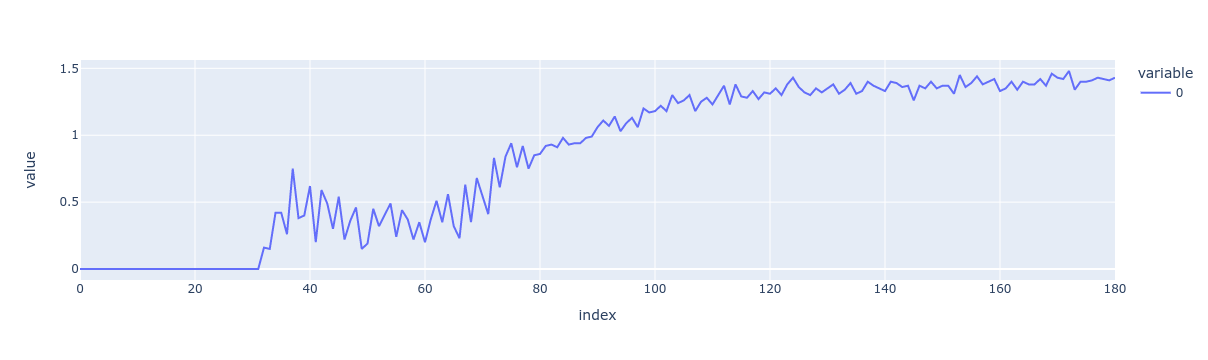

In [266]:
px.line(espresso_flow_weight_raw.sample(1).item())

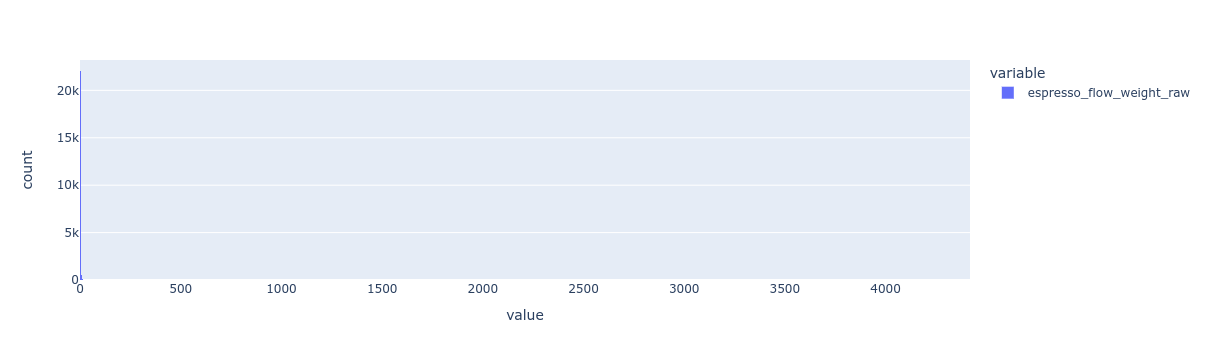

In [145]:
px.histogram(shots_df["espresso_flow_weight_raw"].apply(np.max))

# Saved cleaned file

In [25]:
shots_df.dtypes.to_dict()

{'id': dtype('O'),
 'profile_title': dtype('O'),
 'user_id': dtype('O'),
 'drink_tds': dtype('float64'),
 'drink_ey': dtype('float64'),
 'espresso_enjoyment': dtype('float64'),
 'bean_weight': dtype('float64'),
 'drink_weight': dtype('float64'),
 'grinder_model': dtype('O'),
 'grinder_setting': dtype('float64'),
 'bean_brand': dtype('O'),
 'bean_type': dtype('O'),
 'roast_date': dtype('<M8[ns]'),
 'espresso_notes': dtype('O'),
 'roast_level': dtype('float64'),
 'bean_notes': dtype('O'),
 'start_time': dtype('<M8[ns]'),
 'image_preview': dtype('O'),
 'profile_url': dtype('O'),
 'timeframe': dtype('O'),
 'espresso_flow': dtype('O'),
 'espresso_weight': dtype('O'),
 'espresso_pressure': dtype('O'),
 'espresso_flow_goal': dtype('O'),
 'espresso_resistance': dtype('O'),
 'espresso_flow_weight': dtype('O'),
 'espresso_state_change': dtype('O'),
 'espresso_pressure_goal': dtype('O'),
 'espresso_flow_weight_raw': dtype('O'),
 'espresso_temperature_mix': dtype('O'),
 'espresso_water_dispensed':

In [26]:
todate = datetime.date.today().strftime('%Y-%m-%d')
shots_df.to_parquet(f"../data/raw/visualizercoffee_{shots_df.index.size}shots_{todate}_cleaned.parquet", index=False)

# Show shot data